In [28]:
import torch
import torch.nn as nn
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
grid_range = [122, 148, 24, 46]
resolution = 100

lons = np.linspace(grid_range[0], grid_range[1], resolution)
lats = np.linspace(grid_range[2], grid_range[3], resolution)

# Create a 2D grid of coordinates
lon_grid, lat_grid = np.meshgrid(lons, lats)
grid_inputs = np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T

In [3]:
world = gpd.read_file('C://dropout_MC//dropout_MC//_01_data//data//japan_map//ne_110m_admin_0_countries.shp')
# polygon of Japan
japan_polygon = world[world['ADMIN'] == 'Japan'].geometry.unary_union

# extract points within Japan
points = [Point(lon, lat) for lat, lon in grid_inputs]
filtered_points = [point for point in points if japan_polygon.contains(point)]
filtered_grid_inputs = np.array([[p.y, p.x] for p in filtered_points])

C:\Users\hazi-\AppData\Local\Temp\ipykernel_25540\1503004107.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  japan_polygon = world[world['ADMIN'] == 'Japan'].geometry.unary_union


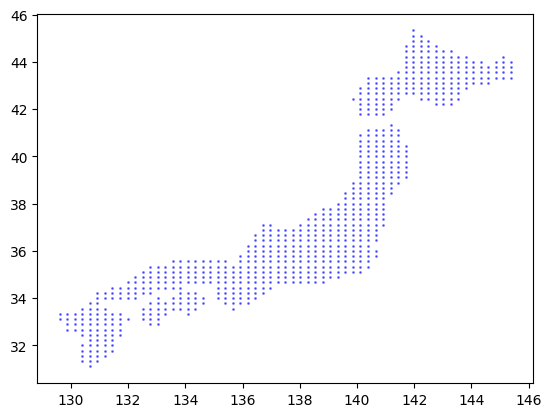

In [6]:
plt.scatter(filtered_grid_inputs[:, 1], filtered_grid_inputs[:, 0], s=1, color='blue', alpha=0.5)

In [16]:
# loade initial model
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.model(x)

model_path = 'C://dropout_MC//dropout_MC//_03_analyze//model//initial_model.pth' 
loaded_model = NN()
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.train()

NN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [9]:
new_inputs = torch.tensor(filtered_grid_inputs, dtype=torch.float32)

In [22]:
mc_iterations = 10
mc_predictions = np.zeros((mc_iterations, new_inputs.shape[0], 1))

with torch.no_grad():
    for i in range(mc_iterations):
        prediction = loaded_model(new_inputs).detach().numpy()
        mc_predictions[i, :] = prediction

In [26]:
pred_mean = np.mean(mc_predictions, axis=0)
pred_var = np.var(mc_predictions, axis=0)

In [38]:
check_uncertainty_df = pd.DataFrame({
    'longitude': filtered_grid_inputs[:, 1],
    'latitude': filtered_grid_inputs[:, 0],
    'mean': pred_mean.flatten(),
    'var': pred_var.flatten()})

In [65]:
def plot_temperature(df, target_col="mean"):
    # 1. 日本のポリゴンだけ取り出す
    shp_fname = shapereader.natural_earth(
    category='cultural',
    name='admin_0_countries',
    #scale='50m'
    )
    reader = shapereader.Reader(shp_fname)
    japan_geoms = [
        rec.geometry
        for rec in reader.records()
        if rec.attributes['ADM0_A3'] == 'JPN'
    ]

    # 2. クリッピング用ボックス（経度 150° まで、緯度は 20–48° の範囲で日本列島全体をカバー）
    clip_box = box(minx=-180, miny= -90, maxx=150, maxy= 90)

    # 3. ポリゴンをボックスと交差させる
    japan_clipped = [geom.intersection(clip_box) for geom in japan_geoms]

    lon_min, lon_max = 122, 145
    lat_min, lat_max = 20, 48

    df_map = df[
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max) &
        (df['latitude']  >= lat_min)  & (df['latitude']  <= lat_max)
    ].copy()

    # 2. プロット
    fig = plt.figure(figsize=(6, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # 2‑a. 地図（日本）を zorder=1 で描画
    ax.add_geometries(
        japan_clipped,
        #japan_geoms,
        crs=ccrs.PlateCarree(),
        facecolor='lightgray',
        edgecolor='black',
        linewidth=1,
        zorder=1
    )

    # 2‑b. 点（観測所）を zorder=2 で描画
    sc = ax.scatter(
        df_map['longitude'],
        df_map['latitude'],
        c=df_map[target_col],
        cmap='coolwarm',
        #cmap='plasma',
        s=10,
        #edgecolor='black',
        transform=ccrs.PlateCarree(),
        zorder=2
    )

    # 3. カラーバー
    cb = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, shrink=0.5)
    cb.set_label('℃')

    # 4. ズーム範囲を日本列島に限定
    ax.set_extent([122, 148, 30, 46], crs=ccrs.PlateCarree())

    # タイトル
    ax.set_title('predict mean', pad=12)

    plt.tight_layout()
    plt.show()


In [66]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import shapereader
from shapely.geometry import box

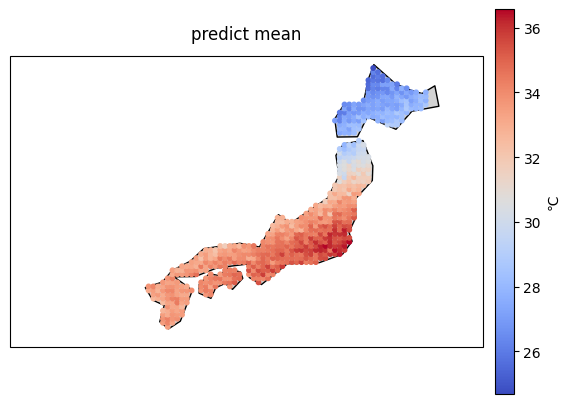

In [67]:
plot_temperature(check_uncertainty_df)

In [48]:
from sklearn.preprocessing import StandardScaler

In [68]:
def plot_uncertainly(df, target_col="var"):
    # 1. 日本のポリゴンだけ取り出す
    shp_fname = shapereader.natural_earth(
    category='cultural',
    name='admin_0_countries',
    #scale='50m'
    )
    reader = shapereader.Reader(shp_fname)
    japan_geoms = [
        rec.geometry
        for rec in reader.records()
        if rec.attributes['ADM0_A3'] == 'JPN'
    ]

    # 2. クリッピング用ボックス（経度 150° まで、緯度は 20–48° の範囲で日本列島全体をカバー）
    clip_box = box(minx=-180, miny= -90, maxx=150, maxy= 90)

    # 3. ポリゴンをボックスと交差させる
    japan_clipped = [geom.intersection(clip_box) for geom in japan_geoms]

    lon_min, lon_max = 122, 145
    lat_min, lat_max = 20, 48

    df_map = df[
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max) &
        (df['latitude']  >= lat_min)  & (df['latitude']  <= lat_max)
    ].copy()

    # 2. プロット
    fig = plt.figure(figsize=(6, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # 2‑a. 地図（日本）を zorder=1 で描画
    ax.add_geometries(
        japan_clipped,
        #japan_geoms,
        crs=ccrs.PlateCarree(),
        facecolor='lightgray',
        edgecolor='black',
        linewidth=1,
        zorder=1
    )

    standard_scaler = StandardScaler()
    df_map[target_col] = standard_scaler.fit_transform(df_map[[target_col]])
    v_min = df_map[target_col].quantile(0.01)
    v_max = df_map[target_col].quantile(0.99)
    # 2‑b. 点（観測所）を zorder=2 で描画
    sc = ax.scatter(
        df_map['longitude'],
        df_map['latitude'],
        c=(df_map[target_col]),
        #cmap='coolwarm',
        cmap='plasma',
        s=10,
        #edgecolor='black',
        transform=ccrs.PlateCarree(),
        zorder=2,
        vmin=v_min,  # ★★★ 最小値を指定 ★★★
        vmax=v_max   # ★★★ 最大値を指定 ★★★
    )

    # # 3. カラーバー
    cb = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, shrink=0.5)
    # cb.set_label('℃')

    # 4. ズーム範囲を日本列島に限定
    ax.set_extent([122, 148, 30, 46], crs=ccrs.PlateCarree())

    # タイトル
    ax.set_title('predict var', pad=12)

    plt.tight_layout()
    plt.show()


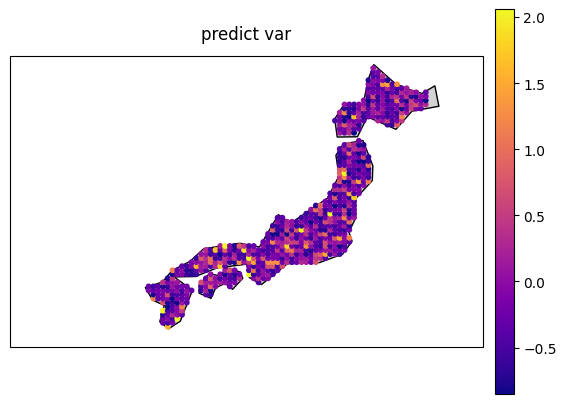

In [69]:
plot_uncertainly(check_uncertainty_df)

In [71]:
from sklearn.model_selection import train_test_split
data = pd.read_csv("C://dropout_MC//dropout_MC//_02_build//data//train_data.csv")
train_data, others_data = train_test_split(data, test_size=0.7, random_state=42)

In [73]:
var_df_sorted = check_uncertainty_df.sort_values(by='var', ascending=False).reset_index(drop=True)

In [84]:
from scipy.spatial.distance import cdist #
var_coords = var_df_sorted[['latitude', 'longitude']].values
station_coords = others_data[['latitude', 'longitude']].values

# compute distance
distance_matrix = cdist(var_coords, station_coords)

matches = []
used_station_indices = set() # 使用済みの観測所のインデックスを記録するセット

for i, var_row in var_df_sorted.iterrows():
    # 現在の不確実性地点と各観測所との距離を取得
    distances = distance_matrix[i]
    
    # 距離が近い順に観測所のインデックスをソート
    sorted_station_indices = np.argsort(distances)
    
    # 最も近い、かつ未使用の観測所を探す
    for station_idx in sorted_station_indices:
        if station_idx not in used_station_indices:
            # マッチング成功
            matched_station = others_data.iloc[station_idx]
            
            matches.append({
                'var_latitude': var_row['latitude'],
                'var_longitude': var_row['longitude'],
                'var_value': var_row['var'],
                'matched_station_name': matched_station['station_name'],
                'matched_station_latitude': matched_station['latitude'],
                'matched_station_longitude': matched_station['longitude'],
                "temp" : matched_station["temp"],
                'distance': distances[station_idx]
            })
            
            # この観測所を使用済みとして記録
            used_station_indices.add(station_idx)
            
            # 次の不確実性地点の処理に移る
            break

# 結果をデータフレームに変換
match_results_df = pd.DataFrame(matches)

In [87]:
match_results_df.to_csv("C://dropout_MC//dropout_MC//_03_analyze//result//match_result_df.csv")